In [1]:

from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler


import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model

from models.detr import SetCriterion
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import argparse

import math
from PIL import Image
import requests
import random

In [2]:
#------------------------------------------------------------------------


def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=100, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    
    ####################### @amirhnazerii #######################
    ##### start 03/27/2025
    # * Classification head
    parser.add_argument('--new_layer_dim', default=None, type=int,
                        help="classification head added fc-layer dim")
    ##### end 03/27/2025
    
    
    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--dataset_file', default='coco')
    parser.add_argument('--coco_path', type=str)
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=2, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
    return parser


#------------------------------------------------------------------------





In [ ]:
!pwd + 'dd'

In [75]:
parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
args = parser.parse_args(args=['--resume', '/home/anazeri/detr_finetune/detr-r50-coco-modifhead-128fc92fc-TEMP/checkpoint0002.pth',
                              '--coco_path', '/scratch/anazeri/coco/val2017',
                              '--new_layer_dim', '128'])
args.batch_size = 1
args.no_aux_loss = True
args.eval = True



# args.resume = 'https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth'
# args.resume = '/scratch/anazeri/outputs11202023_R50_kitti_imgs6481_epch25/eval/checkpoint.pth'
# args.coco_path = '/scratch/anazeri/kitti_coco_format/kitti_val/'

In [76]:
# PATH =  '/home/anazeri/'
# checkpoint = torch.load(PATH + 'detr_finetune/detr-r50-modifhead-128fc92fc.pth', map_location='cpu')
# checkpoint['model'].keys()

In [77]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]



# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()



#------------------------------------------------------------------------

# device = torch.device(args.device)
args.device = 'cpu'

seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
model, criterion, postprocessors = build_model(args)
# model.to(device)
model_without_ddp = model
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)


if args.resume:
    if args.resume.startswith('https'):
        checkpoint = torch.hub.load_state_dict_from_url(
            args.resume, map_location='cpu', check_hash=True)
    else:
        checkpoint = torch.load(args.resume, map_location='cpu')
        
    model_without_ddp.load_state_dict(checkpoint['model'])
    

for param in model.parameters():
    param.requires_grad = False

number of params: 41323488


In [39]:
model_without_ddp

Modified_DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_feature

In [34]:
# checkpoint['model']['class_embed.0.bias']

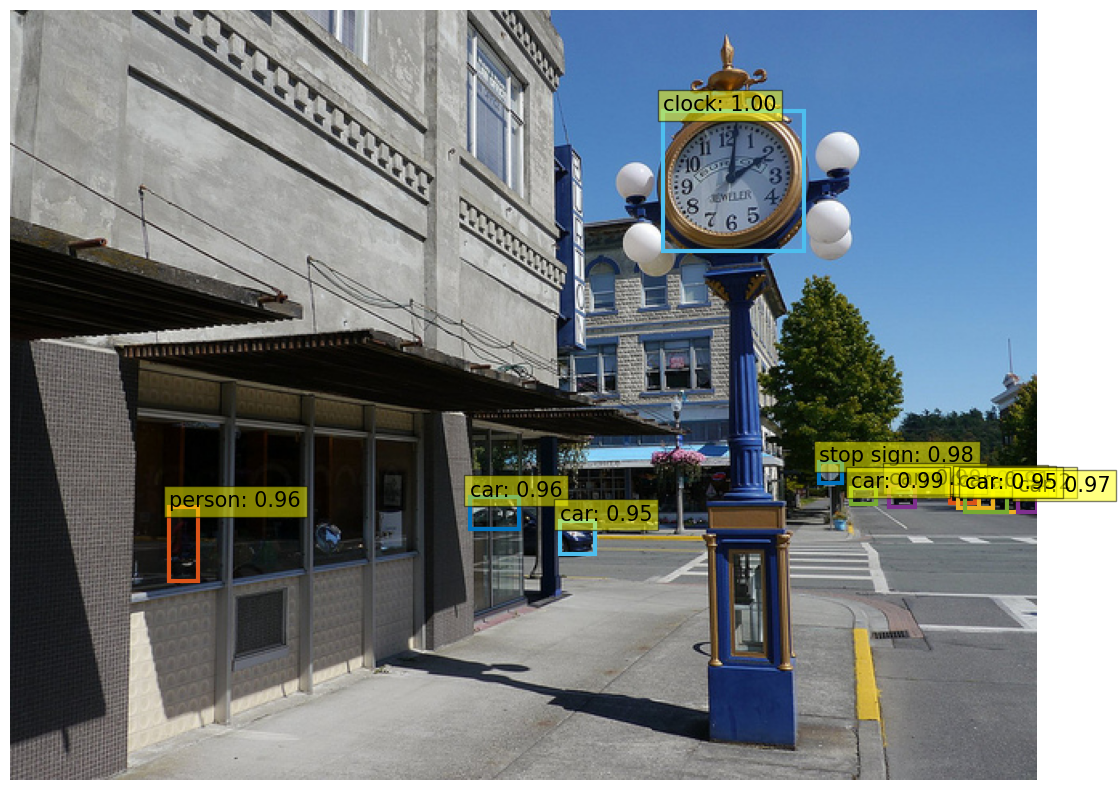

In [78]:
im = Image.open(args.coco_path + '/' + '000000359540.jpg')
359540
# PATH = '/scratch/anazeri/outputs11202023_R50_kitti_imgs6481_epch25/eval/checkpoint.pth'
# checkpoint = torch.load(PATH)
# torch.load_state_dict(checkpoint)
# model.eval()

def ObjDet_one_img(im):

    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9

    # convert boxes from [0; 1] to image scales
    # device = 'cuda'
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)#, device)

    return plot_results(im, probas[keep], bboxes_scaled)

clean= ObjDet_one_img(im)

In [45]:
log_path = '/home/anazeri/detr_finetune/detr-r50-coco-modifhead-128fc92fc-TEMP/eval/latest.pth'
log_last = torch.load(log_path, map_location = 'cpu')

In [67]:
log_last.keys()

dict_keys(['params', 'counts', 'date', 'precision', 'recall', 'scores'])

In [62]:
log_path = '/home/anazeri/detr_finetune/detr-r50-coco-modifhead-128fc92fc-TEMP/log.txt'
logs = []
with open(log_path, 'r') as f:
    for line in f:
        logs.append(json.loads(line))

In [74]:
logs[0].keys()

dict_keys(['train_lr', 'train_class_error', 'train_loss', 'train_loss_ce', 'train_loss_bbox', 'train_loss_giou', 'train_loss_ce_0', 'train_loss_bbox_0', 'train_loss_giou_0', 'train_loss_ce_1', 'train_loss_bbox_1', 'train_loss_giou_1', 'train_loss_ce_2', 'train_loss_bbox_2', 'train_loss_giou_2', 'train_loss_ce_3', 'train_loss_bbox_3', 'train_loss_giou_3', 'train_loss_ce_4', 'train_loss_bbox_4', 'train_loss_giou_4', 'train_loss_ce_unscaled', 'train_class_error_unscaled', 'train_loss_bbox_unscaled', 'train_loss_giou_unscaled', 'train_cardinality_error_unscaled', 'train_loss_ce_0_unscaled', 'train_loss_bbox_0_unscaled', 'train_loss_giou_0_unscaled', 'train_cardinality_error_0_unscaled', 'train_loss_ce_1_unscaled', 'train_loss_bbox_1_unscaled', 'train_loss_giou_1_unscaled', 'train_cardinality_error_1_unscaled', 'train_loss_ce_2_unscaled', 'train_loss_bbox_2_unscaled', 'train_loss_giou_2_unscaled', 'train_cardinality_error_2_unscaled', 'train_loss_ce_3_unscaled', 'train_loss_bbox_3_unscaled'

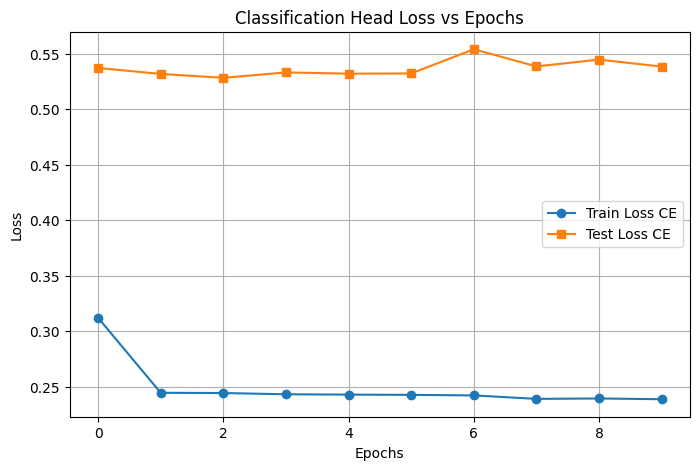

In [66]:
import matplotlib.pyplot as plt

# Extract values
epochs = [entry["epoch"] for entry in logs]
train_loss_ce = [entry["train_loss_ce"] for entry in logs]
test_loss_ce = [entry["test_loss_ce"] for entry in logs]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss_ce, label='Train Loss CE', marker='o')
plt.plot(epochs, test_loss_ce, label='Test Loss CE', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Classification Head Loss vs Epochs')
plt.legend()
plt.grid()
plt.show()